In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from utils import *

PAIR = 0
CORES = scan_ht_cores()[PAIR]
platform = get_uarch()
BIN = f'{BUILD_DIR}/bino'
RES_DIR = Path('results')

if not RES_DIR.exists():
    RES_DIR.mkdir()
assert(RES_DIR.is_dir())


def run_bino(cores, name, iters=5):
    cmd = [BIN, name, ] + cores
    lats = np.zeros(0x200)
    for _ in range(iters):
        lats += run_once(cmd, '-', None)[0][:, 1].astype('float64')
    return lats / iters


def run_contention_effect(cores, alias=True):
    cmd = [BIN, 'contention_effect', ] + cores + [str(int(alias))]
    lats = run_once(cmd, '-', None)[0].astype('float64')
    return lats


ninja: no work to do.


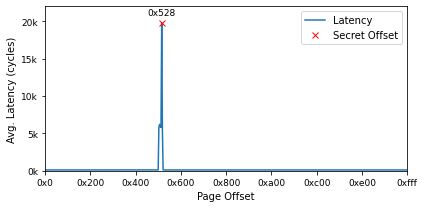

In [2]:
def plot_store_offset(step=5000, **kwargs):
    name = 'store_offset'
    lats = run_bino(CORES, name, **kwargs)

    offsets = np.arange(0, 0x1000, 8)
    peak = max(range(len(lats)), key=lats.__getitem__)
    fig, ax = plt.subplots(figsize=(6, 3))

    ax.plot(offsets, lats, label='Latency')
    ax.plot(offsets[peak], lats[peak], 'rx', label='Secret Offset')
    ax.text(offsets[peak], lats[peak] + 1000, f'{offsets[peak]:#x}', ha='center', fontsize=9)

    ax.set_xlim(offsets[0], offsets[-1])

    max_y = 22000
    ax.set_ylim(0, max_y)

    ax.set_xticks(list(np.arange(0, 0x1000, 0x200)) + [0xfff])
    ax.set_xticklabels([f'{t:#x}' for t in ax.get_xticks()], fontsize=9)

    ax.set_yticks(np.arange(0, max_y + .1, step))
    ax.set_yticklabels([f'{t / 1000:.0f}k' for t in ax.get_yticks()], fontsize=9)

    ax.set_xlabel('Page Offset', fontsize=10)
    ax.set_ylabel('Avg. Latency (cycles)', fontsize=10)
    ax.legend(loc='upper right', fontsize=10)

    fig.tight_layout()
    fig.savefig(RES_DIR / f'prim_{name}_{platform}.pdf', bbox_inches='tight')

plt.close('all')
rebuild()
fig = plot_store_offset(step=5000, iters=1)
plt.show(fig)

ninja: no work to do.


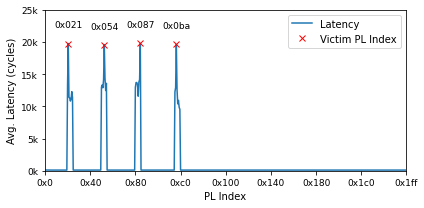

In [3]:
def plot_vpn_throughput(step=2000, **kwargs):
    name = 'vpn_latency'
    lats = run_bino(CORES, name, **kwargs)

    offsets = np.arange(0, 0x200)
    peaks = peak_seeking_std(lats, 4, reverse=False)
    fig, ax = plt.subplots(figsize=(6, 3))

    ax.plot(offsets, lats, label='Latency')
    ax.plot(offsets[peaks], lats[peaks], 'rx', label='Victim PL Index')
    for _, peak in enumerate(peaks):
        ax.text(offsets[peak], lats[peak] + step // 2,
                f'{offsets[peak]:#05x}', ha='center', fontsize=9)

    ax.set_xlim(offsets[0], offsets[-1])

    max_y = np.ceil((ax.get_ylim()[1] + 3000) / step) * step
    ax.set_ylim(0, max_y)

    ax.set_xticks(list(np.arange(0, 0x200, 0x40)) + [0x1ff])
    ax.set_xticklabels([f'{t:#x}' for t in ax.get_xticks()], fontsize=9)

    ax.set_yticks(np.arange(0, max_y + .1, step))
    ax.set_yticklabels([f'{t / 1000:.0f}k' for t in ax.get_yticks()], fontsize=9)

    ax.set_xlabel('PL Index', fontsize=10)
    ax.set_ylabel('Avg. Latency (cycles)', fontsize=10)
    ax.legend(loc='upper right', fontsize=10)

    fig.tight_layout()
    fig.savefig(RES_DIR / f'prim_{name}_{platform}.pdf', bbox_inches='tight')

plt.close('all')
rebuild()
fig = plot_vpn_throughput(step=5000, iters=1)
plt.show(fig)

ninja: no work to do.


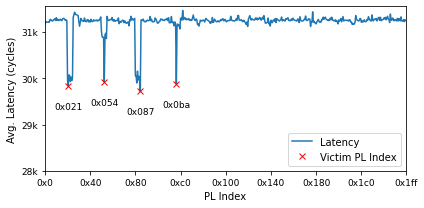

In [8]:
def plot_vpn_contention(step=2000, **kwargs):
    name = 'vpn_contention'
    lats = run_bino(CORES, name, **kwargs)
    offsets = np.arange(0, 0x200)
    peaks = peak_seeking_std(lats, 4, reverse=True)
    fig, ax = plt.subplots(figsize=(6, 3))

    ax.plot(offsets, lats, label='Latency')
    ax.plot(offsets[peaks], lats[peaks], 'rx', label='Victim PL Index')
    for i, peak in enumerate(peaks):
        ax.text(offsets[peak], lats[peak] - step // 2,
                f'{offsets[peak]:#05x}', ha='center', fontsize=9)

    ax.set_xlim(offsets[0], offsets[-1])

    max_y = ax.get_ylim()[1]
    min_y = np.floor(ax.get_ylim()[0] / step - 1) * step
    ax.set_ylim(min_y, max_y)

    ax.set_xticks(list(np.arange(0, 0x200, 0x40)) + [0x1ff])
    ax.set_xticklabels([f'{t:#x}' for t in ax.get_xticks()], fontsize=9)

    ax.set_yticks(np.arange(*ax.get_ylim(), step))
    ax.set_yticklabels([f'{t / 1000:.0f}k' for t in ax.get_yticks()], fontsize=9)

    ax.set_xlabel('PL Index', fontsize=10)
    ax.set_ylabel('Avg. Latency (cycles)', fontsize=10)
    ax.legend(loc='lower right', fontsize=10)

    fig.tight_layout()
    fig.savefig(RES_DIR / f'prim_{name}_{platform}.pdf', bbox_inches='tight')

plt.close('all')
rebuild()
fig = plot_vpn_contention(step=1000, iters=5)
plt.show(fig)

ninja: no work to do.


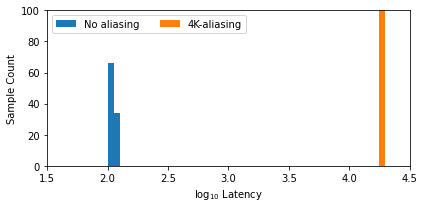

In [29]:
def plot_contention_effect(xlim=(1.5, 4.5), step=.05, nsamples=100, **kwargs):
    no_alias = run_contention_effect(CORES, alias=False)
    fk_alias = run_contention_effect(CORES, alias=True)
    fig, ax = plt.subplots(figsize=(6, 3))
    ax.set_xlim(*xlim)
    ax.set_ylim(0, nsamples)
    ax.hist(np.log10(no_alias), bins=np.arange(*xlim, step), density=False, label='No aliasing')
    ax.hist(np.log10(fk_alias), bins=np.arange(*xlim, step), density=False, label='4K-aliasing')

    ax.set_ylabel('Sample Count', fontsize=10)
    ax.set_xlabel('$\\log_{10}$ Latency', fontsize=10)
    ax.legend(loc='upper left', ncol=2, fontsize=10)
    fig.tight_layout()
    fig.savefig(RES_DIR / f'contention_effect_{platform}.pdf', bbox_inches='tight')

plt.close('all')
rebuild()
fig = plot_contention_effect()
plt.show(fig)